# MLflow + whylogs Integration

In this notebook, we will explore the [MLflow](https://mlflow.org/) integration in `whylogs`.

This example uses the data from [MLflow's tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html) for demonstration purpose.

This tutorial showcases how you can use the whylogs integration to:
* Capture data quality metrics while training a linear regression model in `mlflow`
* Extract whylogs data back into an in-memory format from the MLflow backend
* Visualize this data

For more information about the data and the MLflow, please read the [MLflow's tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html).

# Getting Started
To run this tutorial, you'll need to:
* Install [conda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html)
* Create a new environment with conda via `conda create --name whylogs-mlflow python=3.8`
    * You'll need to activate the environment with `conda activate whylogs-mlflow`
    * You'll need to install pip into the Conda environment `conda install pip`
    * To make the environment work with Jupyter notebooks, run `pip install ipykernel` to install the kernel module
    * Install the environment as a Jupyter notebook kernel via `python -m ipykernel install --user --name=whylogs-mlflow`
* Install MLflow with scikit-learn. You can install this via `pip install mlflow[extras]`
* Install whylogs with matplotlib. You can install this via `pip install whylogs[viz]`
* You can install MLflow (via `pip install mlflow`), whylogs (via `pip install whylogs`), scikit-learn (via `pip install scikit-learn`), and matplotlib (via `pip install matplotlib`) separately.
* In your notebook, ensure you select `whylogs-mlflow` as your kernel

# Setup the environment
First, we want to filter out noisy warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [2]:
import random
import time

import pandas as pd
import mlflow
import whylogs

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

# Enable whylogs Integration

Enable whylogs in MLflow to allow storage of whylogs statistical profiles. This method returns `True` if whylogs is able to patch MLflow

In [3]:
assert whylogs.__version__ >= "0.1.13" # we need 0.1.13 or later for MLflow integration
whylogs.enable_mlflow()

True

# Dataset Preparation

Download and prepare the UCI wine quality dataset. We sample test dataset further to represent batches of datasets produced every second.

In [4]:
# Load wine quality dataset
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(data_url, sep=";")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# Split the data into training and test sets
train, test = train_test_split(data)

We can quickly get a sense of the shape of the training dataset by profiling it with whylogs, so we can compare the baseline data metrics to the profiles of the batches as they flow through our model in the future.

In [6]:
from whylogs import get_or_create_session

with get_or_create_session() as session:
    summary = session.profile_dataframe(train, "training-data").flat_summary()['summary']

summary

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,nunique_str_upper,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,volatile acidity,1199.0,0.0,0.0,1199.0,1.58000,0.524671,0.12000,0.179196,139.0,...,0.0,0.12000,0.20000,0.27000,0.3900,0.52000,0.6400,0.8400,1.0350,1.58000
1,free sulfur dioxide,1199.0,0.0,0.0,1199.0,72.00000,15.806922,1.00000,10.448101,59.0,...,0.0,1.00000,3.00000,4.00000,7.0000,13.00000,22.0000,36.0000,51.0000,72.00000
2,residual sugar,1199.0,0.0,0.0,1199.0,15.40000,2.517681,0.90000,1.386147,82.0,...,0.0,0.90000,1.40000,1.60000,1.9000,2.20000,2.6000,4.8000,8.6000,15.40000
3,chlorides,1199.0,0.0,0.0,1199.0,0.61100,0.087510,0.01200,0.048982,142.0,...,0.0,0.01200,0.04400,0.05200,0.0700,0.07900,0.0900,0.1320,0.3870,0.61100
4,alcohol,1199.0,0.0,0.0,1199.0,14.90000,10.425619,8.40000,1.071456,63.0,...,0.0,8.40000,9.00000,9.20000,9.5000,10.20000,11.1000,12.5000,13.4000,14.90000
5,pH,1199.0,0.0,0.0,1199.0,4.01000,3.310292,2.74000,0.157452,87.0,...,0.0,2.74000,2.92000,3.06000,3.2100,3.31000,3.4000,3.5800,3.7100,4.01000
6,quality,1199.0,0.0,0.0,1199.0,8.00000,5.659716,3.00000,0.817772,6.0,...,0.0,3.00000,4.00000,5.00000,5.0000,6.00000,6.0000,7.0000,8.0000,8.00000
7,total sulfur dioxide,1199.0,0.0,0.0,1199.0,289.00000,46.328607,6.00000,33.163027,140.0,...,0.0,6.00000,8.00000,11.00000,22.0000,38.00000,62.0000,114.0000,151.0000,289.00000
8,citric acid,1199.0,0.0,0.0,1199.0,1.00000,0.273011,0.00000,0.195975,78.0,...,0.0,0.00000,0.00000,0.00000,0.1000,0.26000,0.4300,0.6000,0.7300,1.00000
9,fixed acidity,1199.0,0.0,0.0,1199.0,15.90000,8.327857,4.60000,1.758426,91.0,...,0.0,4.60000,5.20000,6.10000,7.1000,7.90000,9.2000,11.9000,13.2000,15.90000


Now that we've taken a peek at our training data metrics, there's one last item on our to-do list: split the test data into batches, so we can feed them through our model later on.

In [7]:
# Relocate predicted variable "quality" to y vectors
train_x = train.drop(["quality"], axis=1).reset_index(drop=True)
test_x = test.drop(["quality"], axis=1).reset_index(drop=True)
train_y = train[["quality"]].reset_index(drop=True)
test_y = test[["quality"]].reset_index(drop=True)

subset_test_x = []
subset_test_y = []
num_batches = 20
for i in range(num_batches):
    indices = random.sample(range(len(test)), 5)
    subset_test_x.append(test_x.loc[indices, :])
    subset_test_y.append(test_y.loc[indices, :])

# Train the model
We'll train an ElasticNet model using scikit-learn, then run this model for each of the batches of data, logging the model parameters, MAE evaluation metric, and whylogs metrics (from Pandas DataFrame).

Note that whylogs profiler data is automatically logged when `mlflow.end_run()` is called (implicitly or explicitly).

In [8]:
# Create an MLflow experiment for our demo
experiment_name = "whylogs demo"
mlflow.set_experiment(experiment_name)

model_params = {"alpha": 1.0,
                "l1_ratio": 0.7}

lr = ElasticNet(**model_params)
lr.fit(train_x, train_y)
print("ElasticNet model (%s):" % model_params)

INFO: 'whylogs demo' does not exist. Creating a new experiment
ElasticNet model ({'alpha': 1.0, 'l1_ratio': 0.7}):


In [9]:
# run predictions on the batches of data we set up earlier and log whylogs data
for i in range(num_batches):
    with mlflow.start_run(run_name=f"Run {i+1}"):
        batch = subset_test_x[i]
        predicted_output = lr.predict(batch)

        mae = mean_absolute_error(subset_test_y[i], predicted_output)
        print("Subset %.0f, mean absolute error: %s" % (i + 1, mae))

        mlflow.log_params(model_params)
        mlflow.log_metric("mae", mae)

        # use whylogs to log data quality metrics for the current batch
        mlflow.whylogs.log_pandas(batch)

    # wait a bit between runs to create a more natural-looking time series of prediction results
    time.sleep(0.5)

Subset 1, mean absolute error: 0.9127625679296523
Subset 2, mean absolute error: 0.6502998021529844
Subset 3, mean absolute error: 0.6364088122120398
Subset 4, mean absolute error: 0.6722627922587867
Subset 5, mean absolute error: 0.8608878135621417
Subset 6, mean absolute error: 0.5226791707926439
Subset 7, mean absolute error: 0.5833907117863448
Subset 8, mean absolute error: 0.6287192052778489
Subset 9, mean absolute error: 0.7299902181299831
Subset 10, mean absolute error: 0.6016683301296931
Subset 11, mean absolute error: 0.6035090991940126
Subset 12, mean absolute error: 0.670069478057585
Subset 13, mean absolute error: 0.8736354574449022
Subset 14, mean absolute error: 0.5522720716450691
Subset 15, mean absolute error: 0.6766494206611903
Subset 16, mean absolute error: 0.745343417538396
Subset 17, mean absolute error: 0.724872484993846
Subset 18, mean absolute error: 0.4575810013965397
Subset 19, mean absolute error: 0.6276057073134484
Subset 20, mean absolute error: 0.619563555

# Accessing whylogs Data From Your Experiment
Now, let's explore our whylogs data inside the MLflow experiment.

In [10]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
experiment.name, experiment.experiment_id

('whylogs demo', '1')

MLflow stores the data profiles as *artifacts*. These can be retrieved in the same way you access MLflow projects, parameters, and metrics.

whylogs exposes helper API for accessing whylogs-specific output of an experiment.

In [11]:
whylogs.mlflow.list_whylogs_runs(experiment.experiment_id)

[<RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/3b6fa8fce21845c3905b420c33bb7d11/artifacts', end_time=1612489049055, experiment_id='1', lifecycle_stage='active', run_id='3b6fa8fce21845c3905b420c33bb7d11', run_uuid='3b6fa8fce21845c3905b420c33bb7d11', start_time=1612489049032, status='FINISHED', user_id='alex'>,
 <RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/eaf9a56af9954a48946b99d6b010b37c/artifacts', end_time=1612489048528, experiment_id='1', lifecycle_stage='active', run_id='eaf9a56af9954a48946b99d6b010b37c', run_uuid='eaf9a56af9954a48946b99d6b010b37c', start_time=1612489048499, status='FINISHED', user_id='alex'>,
 <RunInfo: artifact_uri='file:///Users/alex/Code/whylogs-examples/python/mlruns/1/ba1bb7130b66468faea55bd2d81d9f1b/artifacts', end_time=1612489047992, experiment_id='1', lifecycle_stage='active', run_id='ba1bb7130b66468faea55bd2d81d9f1b', run_uuid='ba1bb7130b66468faea55bd2d81d9f1b', start_time=1612489047969

# Visualizing whylogs Data
Our integration allows you to quickly collect the statistical profiles produced during experimentation.

In [12]:
mlflow_profiles = whylogs.mlflow.get_experiment_profiles(experiment.experiment_id)
mlflow_profiles

You can then use `whylogs.viz` to easily produce visualizations for the whylogs profile data.

Below, you can see how the data changed for the column called `free sulfur dioxide` in our batches over time.

In [13]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(mlflow_profiles)

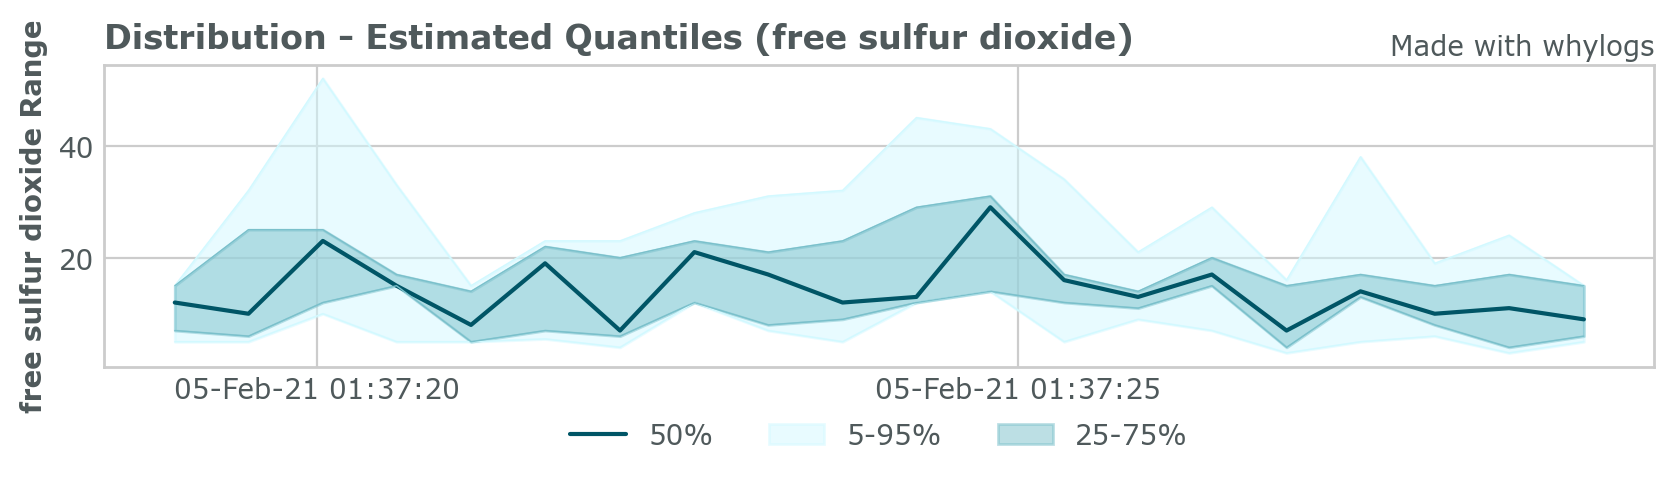

In [14]:
viz.plot_distribution("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

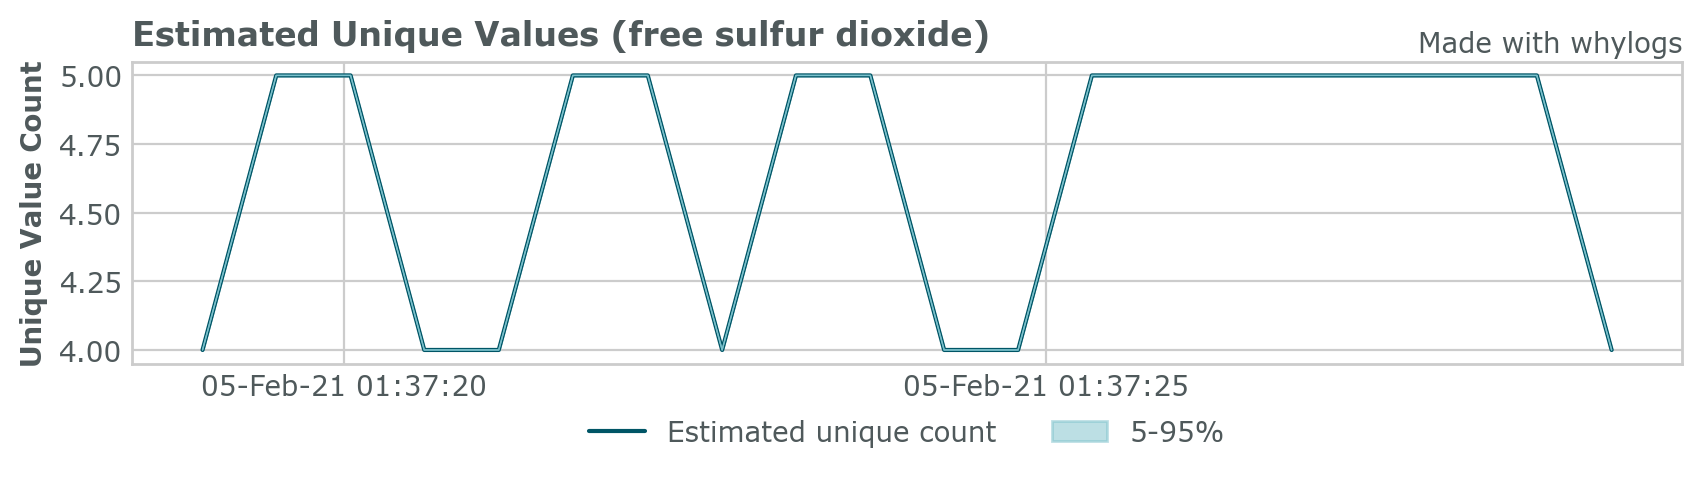

In [15]:
viz.plot_uniqueness("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

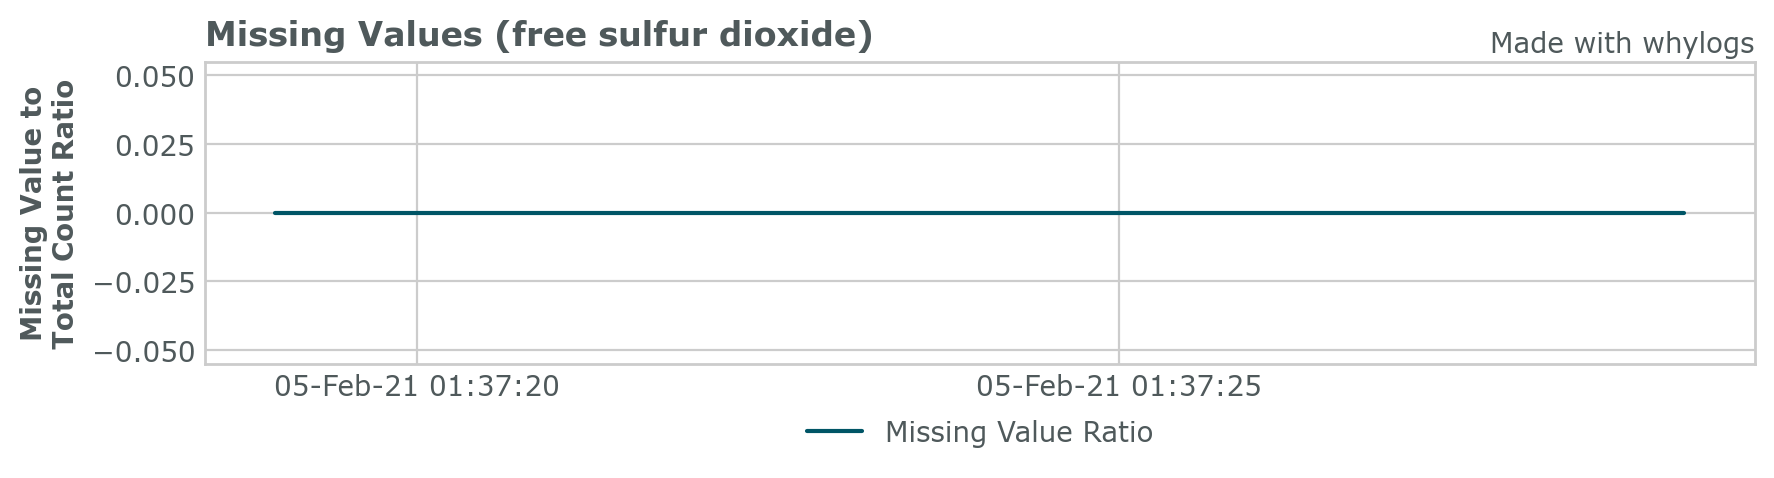

In [16]:
viz.plot_missing_values("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

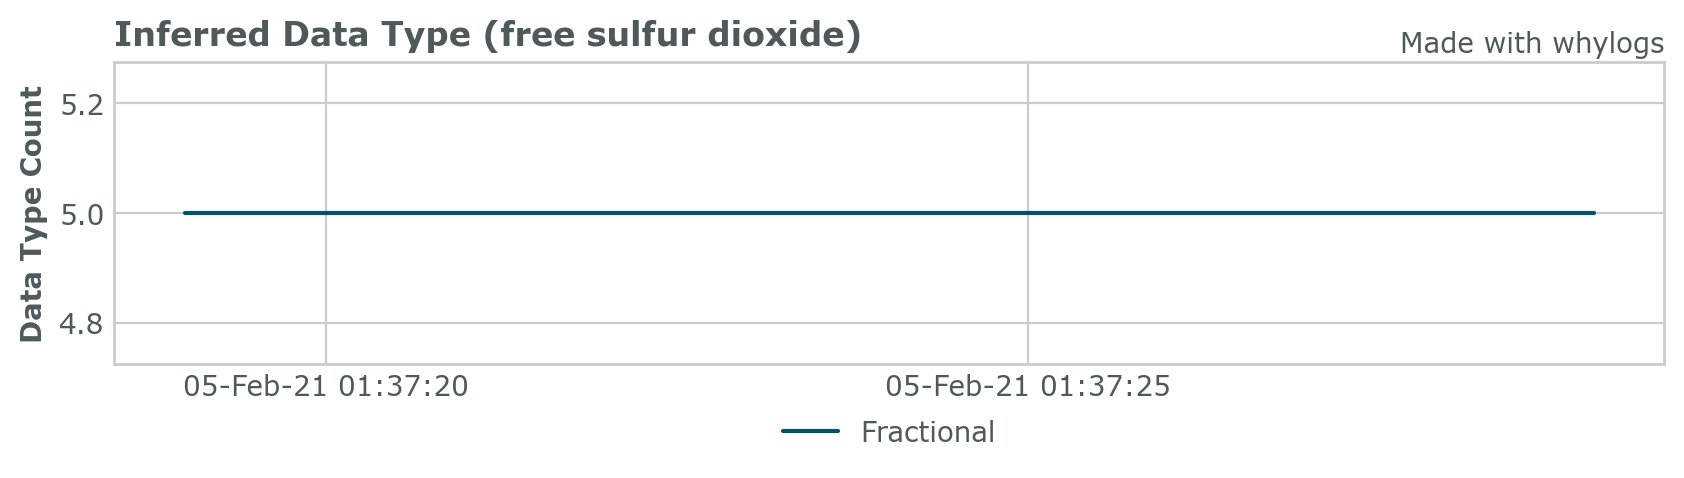

In [17]:
viz.plot_data_types("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

We can also plot the mean error of each run for comparison.

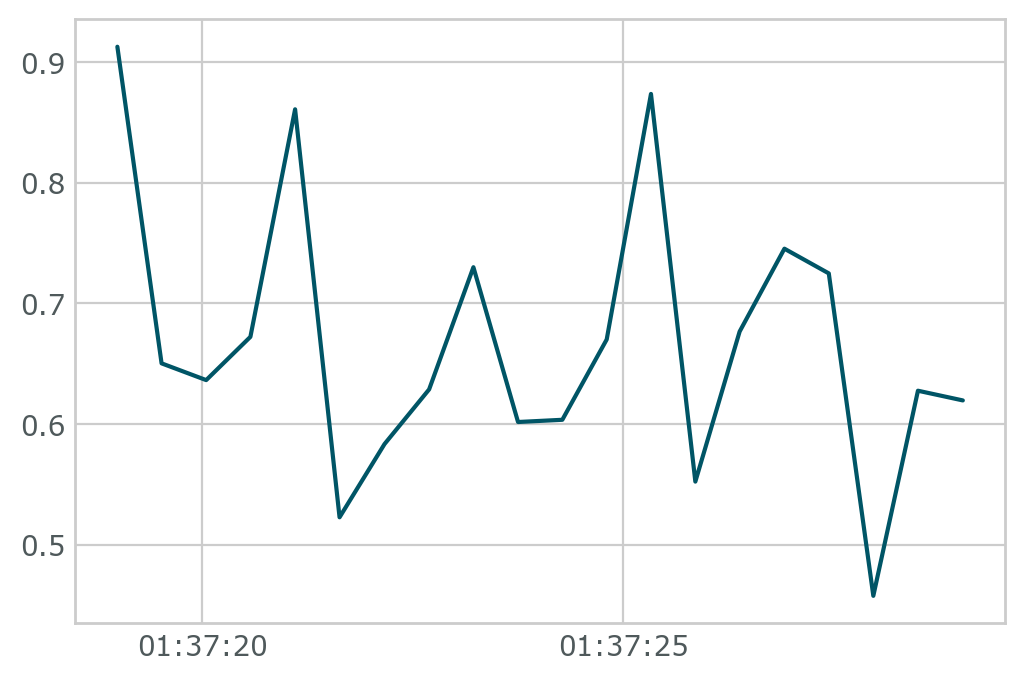

In [18]:
import matplotlib.pyplot as plt

runs = mlflow.search_runs(experiment.experiment_id)
plt.close('all')
plt.plot(runs['start_time'], runs['metrics.mae'])
plt.show()

By combining MLflow with whylogs, it is easy to collect and visualize data quality metrics at both training and inference time. This can be helpful when trying to debug model failures or optimize their performance.

whylogs data can be visualized in more complex ways. Check out [whylogs.viz](https://whylogs.readthedocs.io/en/latest/api/whylogs.viz.html) for details on the API.

In addition, you can also check out how **WhyLabs** can help you visualize data quality metrics by visiting [our sandbox](http://try.whylabsapp.com/). Feel free to reach out to our [slack channel](http://join.slack.whylabs.ai/) if you have any questions!